# 1. Übungsblatt: Implementieren eines Perzeptrons
## 1. Daten einlesen
Lesen Sie zunächst die Dateien `Train.txt` und `Val.txt` ein. Die ersten beiden Spalten beider Dateien entsprechen den Eingabedaten. Die dritte bzw. letzte Spalte entspricht den Labels. Trennen Sie die Daten so auf, dass:


*   `x_train` alle Eingabedaten für das Training enthält.
*   `y_train` alle Labels für das Training enthält.
*   `x_val` alle Eingabedaten für die Validierung enthält.
*   `y_val` alle Labels für die Validierung enthält.


In [1]:
import numpy as np
# Damit die Ergebnisse reproduzierbar sind.
np.random.seed(1)

def read_data(path):
    data = np.loadtxt(path)
    x_data = data[:, :2].astype(float)
    y_data = data[:, 2].astype(int)
    return x_data, y_data

# Daten einlesen
x_train, y_train = read_data('Train.txt')
x_val, y_val = read_data('Val.txt')

## 2. Visualisieren der Daten
Schreiben Sie eine Methode, die alle Trainings und Validierungsdaten visualisiert. Verwenden Sie hierfür das Paket matplotlib.

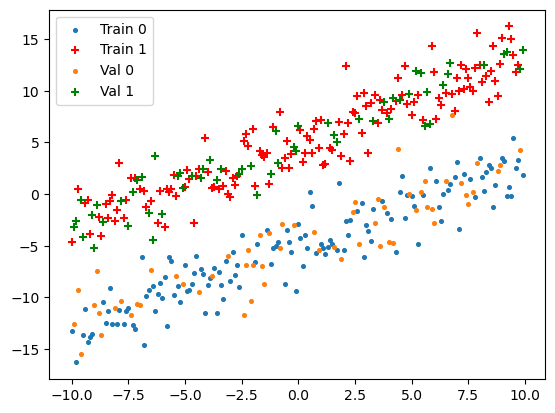

In [2]:
import matplotlib.pyplot as plt

train0 = np.array([x_train[i] for i in range(len(x_train)) if y_train[i] == 0])
train1 = np.array([x_train[i] for i in range(len(x_train)) if y_train[i] == 1])
val0 = np.array(([x_val[i] for i in range(len(x_val)) if y_val[i] == 0]))
val1 = np.array(([x_val[i] for i in range(len(x_val)) if y_val[i] == 1]))

plt.scatter(train0[:,0],train0[:,1], s = 7, label = "Train 0")
plt.scatter(train1[:,0],train1[:,1], marker='+', c="red", label = "Train 1")
plt.scatter(val0[:,0],val0[:,1], s = 7, label = "Val 0")
plt.scatter(val1[:,0],val1[:,1], marker='+', c="green", label = "Val 1")
plt.legend()

plt.show()

## 3. Implementieren eines Perzeptrons
In dieser Aufgabe soll ein einfaches Perzeptron (d.h. beliebig viele Eingabeneuronen und ein Ausgabeneuron) als Klasse implementiert werden. Zunächst beginnen wir mit einigen imports und der Installation des Paketes `jdc`.

In [3]:
import sys
# Um die Klassendefinition auf mehrere Zellen verteilen zu können.
# !{sys.executable} -m pip install jdc
import jdc

Jetzt definieren wir die Klasse `Perceptron` und den Konstruktor. Der Konstruktor nimmt zwei Parameter:


1.   `input_neurons` eine natürliche Zahl > 0
2.   `learning_rate` eine rationale Zahl > 0

Als Klassenvariablen soll folgendes gespeichert werden:


1.   Die Gewichte `weights` zwischen Eingabeschicht und Ausgabeschicht.
2.   Der Bias `bias`.
3.   Die Lernrate `learning_rate`.

Verwenden Sie für die Initialisierung der Gewichte und des Biases, gleichverteilte Werte zwischen -0.01 und 0.01.





In [4]:
class Perceptron:
    def __init__(self, input_neurons, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.input_neurons = input_neurons
        self.weights = np.random.uniform(-0.01,0.01,input_neurons)
        self.bias = np.random.uniform(-0.01,0.01)


<!---
Als nächstes sollen Sie die Aktivierungsfunktion implementieren. Zur Erinnerung: Ein Perzeptron verwendet die Heavyside-Funktion:
$$a: \mathbb{R} \rightarrow \{0,1\}, \ z \mapsto \begin{cases} 1 \hspace{2mm} & \text{wenn } z > 0 \\[3pt] 0 & \text{sonst}\\ \end{cases}$$

Als nächstes sollen Sie die Aktivierungsfunktion implementieren. Statt der standardmäßigen Heaviside-Funktion, sollen Sie ReLu als Aktivierungsfunktion implementieren. Diese ist wie folgt definiert:
$$ReLu: \mathbb{R} \rightarrow [0,\infty[, \ z \mapsto \begin{cases} z \hspace{2mm} & \text{wenn } z > 0 \\[3pt] 0 & \text{sonst}\\ \end{cases}$$
--->

Als nächstes sollen Sie die Aktivierungsfunktion und deren Ableitung implementieren. Da die standardmäßige Heaviside-Funktion nicht differenzierbar ist, verwenden wir die Sigmoid-Funktion als Aktivierungsfunktion. Diese ist wie folgt definiert:
$$\sigma : \mathbb{R} \rightarrow [0,1], \ z \mapsto \frac{1}{1 + e^{-z}}$$

In [5]:
%%add_to Perceptron
def sigmoid(self, z):
    return 1/(1+np.exp(-z))

def sigmoid_dx(self, z):
    return np.exp(-z) / (1 + np.exp(-z))**2

Implementieren Sie jetzt die Forward-Pass Methode. Verwenden Sie `self.weights` und `self.bias` um auf die Klassenvariablen zuzugreifen.

**Hinweis:** Die Forward-Pass Methode ist definiert als:
$$\sum\limits_{i = 1}^{n} w_{i}x_{i} + b = w^Tx + b$$
Dadurch, dass wir Sigmoid als Aktivierungsfunktion wählen, kann die Ausgabe im Intervall [0,1] liegen. Da wir allerdings ein binäres Klassifizierungsproblem betrachten, sollte die Ausgabe entweder 0 oder 1 sein. Daher runden wir die Ausgabe des Perzeptrons.

In [6]:
%%add_to Perceptron
def forward_pass(self, x):
    return np.dot(x,self.weights) + self.bias

In [7]:
%%add_to Perceptron
def predict(self,a):
    return np.array([np.round(i) for i in self.sigmoid(self.forward_pass(a))])

#### Exkurs zur Backpropagation
In diesem Abschnitt soll die Backpropagation implementiert werden. Bevor wir damit loslegen können, benötigen wir noch Informationen zu der zu verwendeten Fehlerfunktion/Loss. Um die Aufgabe möglichst einfach zu gestallten verwenden wir eine modifizierte Form des Mean Squared Errors (MSE). Diese ist definiert als:
$$Loss(y_{GT}, y_{pred}) := \frac{1}{2}\left(y_{GT} - y_{pred} \right) ^2 $$
Hierbei entspricht $y_{GT}$ der tatsächlichen Ausgabe (Ground Truth) und $y_{pred}$ der vorhergesagten Ausgabe (Prediction). 

Die Backpropagation wird dazu verwendet um, die <u>Gewichtsunterschiede</u> $\Delta w$ und $\Delta b$ zu <u>berechnen</u>. Sie ist jedoch nicht für die Durchführung der Gewichtsaktualisierungen verantwortlich. Für Letzteres werden Optimierungsalgorithmnen wie z.B. (Stochastic) Gradient Descent, Adam oder (im Machine Learning etwas seltener) BFGS (Broyden–Fletcher–Goldfarb–Shanno) verwendet.

Um $\Delta w$ berechnen zu können müssen wir die zu minimierende Fehlerfunktion/Loss nach $w$ ableiten. Zur Vereinfachung legen wir fest, dass $z := w^Tx + b$. Damit ergibt sich:
\begin{align}
\frac{\partial}{\partial w}\frac{1}{2}\left(y_{GT} - y_{pred} \right) ^2 & = \frac{\partial}{\partial w} \frac{1}{2}\left(y_{GT} - \sigma(w^Tx + b) \right) ^2 \\
                                              & = \frac{\partial Loss}{\partial y_{pred}} \frac{\partial y_{pred}}{\partial z} \frac{\partial z}{\partial w} \\
                                              & = \left(y_{GT} - \sigma(w^Tx + b) \right) \cdot -\sigma'(w^Tx + b) \cdot x \\
\end{align}
und für $\Delta b$ ergibt sich analog:
$$\frac{\partial}{\partial w}\frac{1}{2}\left(y_{GT} - y_{pred} \right) ^2 = \left(y_{GT} - \sigma(w^Tx + b) \right) \cdot -\sigma'(w^Tx + b)$$

In [8]:
%%add_to Perceptron
def backpropagation(self, x_transposed, y_GT,y_pred): #y_pred
    weights_delta = (y_GT - self.sigmoid(y_pred)) * (-self.sigmoid_dx(y_pred)) * x_transposed
    bias_delta = (y_GT - self.sigmoid(y_pred)) * (-self.sigmoid_dx(y_pred))
    return weights_delta, bias_delta

In der folgenden Methode sollen Sie den Gradient Descent Algorithmus implementieren, um die Gewichte in `w` und den Bias `b` zu aktualisieren. Gehen Sie davon aus, dass die Gradienten durch `weights_delta` und `bias_delta` gegeben sind.

In [9]:
%%add_to Perceptron
def gradient_descent(self, weights_delta, bias_delta):
    self.weights -= self.learning_rate * weights_delta
    self.bias -= self.learning_rate * bias_delta

Vervollständigen Sie jetzt die `evaluate` Methode. Diese nimmt zwei obligatorische Parameter `x_val` (Modelleingabe) und `y_val` (erwartete Modellausgabe) und berechnet die **Confusion Matrix**. Zusätzlich soll die Methode den **Recall**, **Precision** und den $F_1$**-Score** berechnen und zurückgeben. Der optionale Parameter `print_F1` soll regeln, ob der berechnete $F_1$**-Score** auch ausgeben wird.

In [10]:
%%add_to Perceptron
def evaluate(self, x_val, y_val, print_F1=True):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for (m,ground_truth) in zip (self.sigmoid(self.forward_pass(x_val)),y_val):
        predicted_val = round(m)
        if ground_truth == 1:
            if predicted_val == 1:
                TP += 1
            else:
                FN += 1
        else:
            if predicted_val == 1:
                FP += 1
            else:
                TN += 1
    Recall = (TP+FN) and TP/(TP+FN) or 0
    Precision = (TP+FP) and TP/(TP+FP) or 0
    F1_Score = (2*TP+FP+FN) and 2*TP/(2*TP+FP+FN) or 0
    
    if print_F1:
        print(f'F1_Score: {F1_Score}')
    return Recall, Precision, F1_Score, TP, TN, FP, FN

Vervollständigen Sie nun die Methode `train`. Diese nimmt die Trainingsdaten `x_train` (Eingabe) und `y_train` (Label) und Validierungsdaten `x_val` (Eingabe) und `y_val` (Label). Mit dem Parameter `max_epochs` legen Sie die Anzahl der Epochen fest, die trainiert werden sollen. Wenn Sie möchten (kein Muss für volle Punktzahl), können Sie mit Batches > 1 trainieren.

***Hinweis***
Der Teil, den Sie noch vervollständigen sollen ist mit #ToDo markiert. Es geht darum die zuvor definierten Methoden in der richtigen Reihenfolge aufzurufen.

In [11]:
%%add_to Perceptron
def train(self, x_train, y_train, x_val, y_val, max_epochs):
    for epoch in range(max_epochs):
        print("Epoch:", epoch)
        for phase in ["Train", "Val"]:
            epoch_loss = 0
            if phase == "Train":
                dataset, labels = x_train, y_train
            else:
                dataset, labels = x_val, y_val
            for i, (x_transposed, y_GT) in enumerate(zip(dataset, labels)):
                y_pred = self.forward_pass(x_transposed)
                delta_w, delta_b = self.backpropagation(x_transposed,y_GT,y_pred)
                self.gradient_descent(delta_w,delta_b)
                epoch_loss += (y_GT - y_pred)**2
            print(phase + " Loss =", round(epoch_loss / len(labels), 4))
        self.evaluate(x_val, y_val,True)

Erzeugen Sie ein Objekt der Klasse Perzeptron und trainieren Sie das Perzeptron. Probieren Sie unterschiedliche Lernraten, Werte zwischen 0.0001 und 0.01 sollten gute Ergebnisse erzielen. Testen Sie auch unterschiedliche Werte für die Anzahl der Epochen. Bei diesem Beispiel sollten bei geeigneter Lernrate, 5 Epochen ausreichend sein.

<!--
Was fällt Ihnen auf? Welchen Trainings und welchen Validierungsfehler bekommen Sie?
-->

In [12]:
perceptron = Perceptron(2,0.01)
perceptron.train(x_train,y_train,x_val,y_val,5)

Epoch: 0
Train Loss = 1.4893
Val Loss = 2.7707
F1_Score: 0.9833333333333333
Epoch: 1
Train Loss = 4.3916
Val Loss = 5.0852
F1_Score: 0.9833333333333333
Epoch: 2
Train Loss = 6.3971
Val Loss = 6.7825
F1_Score: 0.9833333333333333
Epoch: 3
Train Loss = 7.9577
Val Loss = 8.1547
F1_Score: 0.9833333333333333
Epoch: 4
Train Loss = 9.2608
Val Loss = 9.3239
F1_Score: 0.9833333333333333


Schreiben Sie eine Methode `find_hyperplane()`, die die Trennfläche des Modells repräsentiert.

-7.845264673233032|7.896286249160767


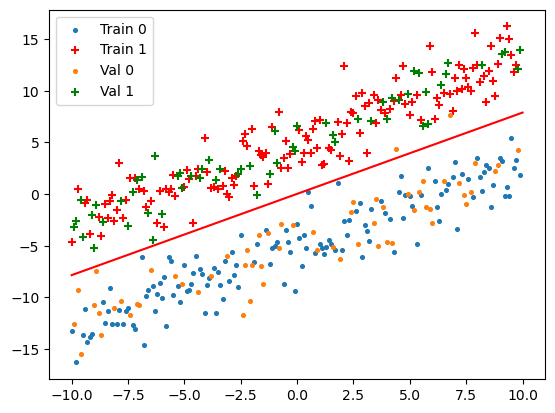

In [13]:
%%add_to Perceptron
def find_hyperplane(self):
    x1 = bisect(lambda y: perceptron.predict(np.array([[-10,y]])),-50, 50)
    x2 = bisect(lambda y: perceptron.predict(np.array([[10,y]])),-50, 50)
    print(f'{x1}|{x2}')
    return x1, x2
    
def bisect(f, a, b, tol=1e-5):
    # Prüfe ob Wechsel vorhanden
    if f(a) == f(b):
        return None
    c = a
    while (b-a) >= tol:
        c = (a+b)/2
        # prüft in welchem Teil der Wechsel ist und passt gibt c in a/b
        if f(c) == f(b):
            b = c
        else:
            a = c
    return c
    
x1, x2 = find_hyperplane(perceptron)

figure = plt.figure()
ax = plt.subplot()
ax.scatter(train0[:,0],train0[:,1], s = 7, label = "Train 0")
ax.scatter(train1[:,0],train1[:,1], marker='+', c="red", label = "Train 1")
ax.scatter(val0[:,0],val0[:,1], s = 7,label = "Val 0")
ax.scatter(val1[:,0],val1[:,1], marker='+', c="green", label = "Val 1")
plt.plot([-10, 10],[x1,x2],c="red")
plt.legend()
plt.show()
    


Denken Sie sich selbst eigene Punkte aus, die Sie anschließend von dem Perzeptron zuordnen lassen.

-7.845264673233032|7.896286249160767


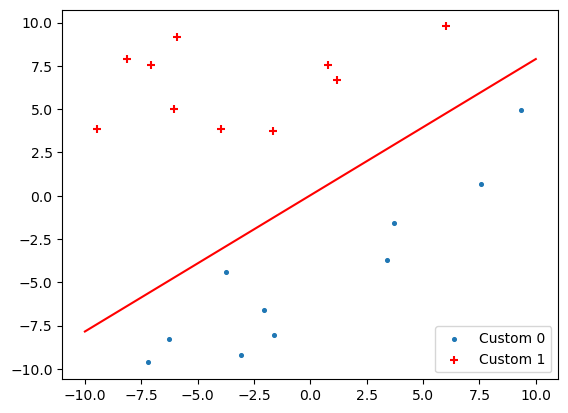

In [14]:
custom_val_x = np.array([np.random.uniform(-10,10,20),np.random.uniform(-10,10,20)]).T
custom_val_y = np.array(perceptron.predict(custom_val_x))

custom0 = np.array([custom_val_x[i] for i in range(len(custom_val_x)) if custom_val_y[i] == 0])
custom1 = np.array([custom_val_x[i] for i in range(len(custom_val_x)) if custom_val_y[i] == 1])

x1, x2 = perceptron.find_hyperplane()

figure = plt.figure()
ax = plt.subplot()
ax.scatter(custom0[:,0],custom0[:,1], s = 7, label = "Custom 0")
ax.scatter(custom1[:,0],custom1[:,1], marker='+', c="red", label = "Custom 1")
plt.plot([-10, 10],[x1,x2],c="red")
plt.legend()
plt.show()

Visualisieren Sie zum Schluss noch die Confusion Matrix, die durch die Evaluation des Perzeptrons auf den Validierungsdaten entsteht.

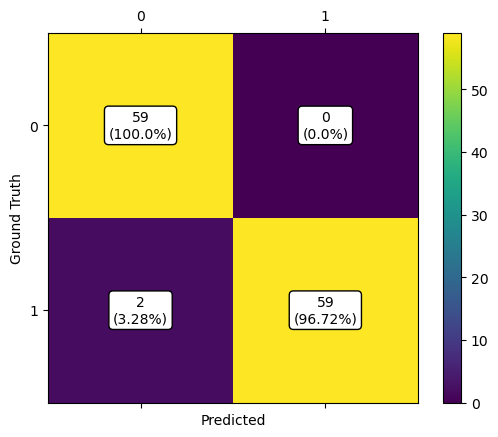

In [15]:
_,_,_,tp,tn,fp,fn = perceptron.evaluate(x_val,y_val,False)
a = np.array([[tn,fn],[fp,tp]])

figure = plt.figure()
axes = figure.add_subplot()
caxes = axes.matshow(a)

for (i, j), z in np.ndenumerate(a):
    axes.text(j, i, f'{z}\n({round(z*100/a[i].sum(), 2)}%)', ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white'))

figure.colorbar(caxes)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()